In [ ]:
!pip install pyAgrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# predict function
def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations
    using a bayesian network model.

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i)
                           for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        # Set the evidence
        inf_bn.setEvidence(data_records[i])
        # Run inference
        inf_bn.makeInference()
        # Compute posterior probability of target variable
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        # Erase evidence
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

# Exploration des données

In [ ]:
calls_dfd = {}
data_filename = f"calls_a2.csv.bz2"
print(f"Chargement du fichier {data_filename}")
calls_dfd[f"a2"] = pd.read_csv(
    data_filename,
    parse_dates=[f"date_a{k_bis}" for k_bis in range(1, 3)],
)

Chargement du fichier calls_a2.csv.bz2


In [ ]:
calls_dfd["a2"].head(5)

,lead_id,date_a1,weekday_a1,hour_a1,duration_a1,caller_id_a1,lead_answered_a1,date_a2,weekday_a2,hour_a2,duration_a2,caller_id_a2,lead_answered_a2,caller_has_changed_a2
0,fdeae76d3fef,2020-04-03 10:05:49,0Monday,h10,2,1e540d0ac463,no,2020-04-06 18:28:15,3Thursday,h18,2,08fcb33240a2,no,yes
1,73c015525161,2020-04-03 10:05:50,0Monday,h10,2,159e9c0a04f6,no,2020-04-06 18:28:15,3Thursday,h18,2,f986b4d3e9dd,no,yes
2,c718221df1be,2020-04-03 10:06:01,0Monday,h10,3,da44d3138279,no,2020-04-06 18:28:16,3Thursday,h18,3,b7824c80c481,no,yes
3,912712707f41,2020-04-03 10:07:54,0Monday,h10,2,1a3960780bb2,no,2020-04-06 18:28:16,3Thursday,h18,2,385232287fc4,no,yes
4,6b6797b56ae7,2020-04-03 10:08:05,0Monday,h10,3,1a3960780bb2,no,2020-04-06 18:28:16,3Thursday,h18,23,385232287fc4,yes,yes


In [ ]:
calls_dfd["a2"].describe(include="O")

,lead_id,weekday_a1,hour_a1,caller_id_a1,lead_answered_a1,weekday_a2,hour_a2,caller_id_a2,lead_answered_a2,caller_has_changed_a2
count,2824096,2824096,2824096,2824096,2824096,2824096,2824096,2824096,2824096,2824096
unique,2761053,5,9,900,1,5,9,987,2,2
top,40f09fe86afe,2Wednesday,h11,094fd601829a,no,3Thursday,h11,094fd601829a,no,yes
freq,3,620362,371260,56839,2824096,711154,387335,56846,2378305,2750376


In [ ]:
calls_dfd["a2"]["lead_answered_a2"].value_counts()

lead_answered_a2
no     2378305
yes     445791
Name: count, dtype: int64

In [ ]:
len(calls_dfd["a2"])

2824096

# Préparation des données

In [ ]:
var_cat = ["weekday_a1", "hour_a1", "weekday_a2", "hour_a2", "caller_has_changed_a2", "lead_answered_a2"]
for var in var_cat:
    calls_dfd["a2"][var] = calls_dfd["a2"][var].astype('category')

calls_dfd["a2"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824096 entries, 0 to 2824095
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   lead_id                object        
 1   date_a1                datetime64[ns]
 2   weekday_a1             category      
 3   hour_a1                category      
 4   duration_a1            int64         
 5   caller_id_a1           object        
 6   lead_answered_a1       object        
 7   date_a2                datetime64[ns]
 8   weekday_a2             category      
 9   hour_a2                category      
 10  duration_a2            int64         
 11  caller_id_a2           object        
 12  lead_answered_a2       category      
 13  caller_has_changed_a2  category      
dtypes: category(6), datetime64[ns](2), int64(2), object(4)
memory usage: 188.5+ MB


In [ ]:
var_to_model = ["weekday_a1", "hour_a1", "weekday_a2", "hour_a2", "caller_has_changed_a2", "lead_answered_a2"]

X = calls_dfd["a2"][var_to_model]
y = calls_dfd["a2"]["lead_answered_a2"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_test = X_test.drop(columns=['lead_answered_a2'])
X_test

,weekday_a1,hour_a1,weekday_a2,hour_a2,caller_has_changed_a2
2802135,4Friday,h12,4Friday,h16,yes
1422470,0Monday,h12,0Monday,h16,yes
1899589,0Monday,h10,1Tuesday,h16,yes
2014809,2Wednesday,h12,0Monday,h11,yes
24274,0Monday,h14,4Friday,h10,yes
...,...,...,...,...,...
185564,2Wednesday,h15,3Thursday,h10,yes
1381535,4Friday,h16,2Wednesday,h12,yes
137709,1Tuesday,h15,2Wednesday,h18,yes
1073928,1Tuesday,h17,2Wednesday,h18,yes


In [ ]:
X_test.value_counts()

weekday_a1  hour_a1  weekday_a2  hour_a2  caller_has_changed_a2
2Wednesday  h12      3Thursday   h15      yes                      4017
1Tuesday    h19      2Wednesday  h10      yes                      3740
            h11      2Wednesday  h12      yes                      3628
            h10      2Wednesday  h11      yes                      3251
4Friday     h18      4Friday     h18      yes                      2785
                                                                   ... 
            h11      4Friday     h15      no                          1
2Wednesday  h12      2Wednesday  h16      no                          1
                                 h12      no                          1
                     1Tuesday    h18      no                          1
4Friday     h11      2Wednesday  h10      no                          1
Name: count, Length: 1962, dtype: int64

# Préparation du modèle

In [ ]:
var_bn = {}
for var in var_to_model:
    nb_values = len(calls_dfd["a2"][var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

In [ ]:
for var in var_bn:
    for i, modalite in enumerate(calls_dfd["a2"][var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

In [ ]:
var_bn

{'weekday_a1': (pyAgrum.LabelizedVariable@0x5c20656830f0) weekday_a1:Labelized({0Monday|1Tuesday|2Wednesday|3Thursday|4Friday}),
 'hour_a1': (pyAgrum.LabelizedVariable@0x5c20663939b0) hour_a1:Labelized({h10|h11|h12|h14|h15|h16|h17|h18|h19}),
 'weekday_a2': (pyAgrum.LabelizedVariable@0x5c20674e0aa0) weekday_a2:Labelized({0Monday|1Tuesday|2Wednesday|3Thursday|4Friday}),
 'hour_a2': (pyAgrum.LabelizedVariable@0x5c2066bd9f00) hour_a2:Labelized({h10|h11|h12|h14|h15|h16|h17|h18|h19}),
 'caller_has_changed_a2': (pyAgrum.LabelizedVariable@0x5c2066836980) caller_has_changed_a2:Labelized({no|yes}),
 'lead_answered_a2': (pyAgrum.LabelizedVariable@0x5c2065e09290) lead_answered_a2:Labelized({no|yes})}

# Modèle naïf

In [ ]:
# Entrainement
bn_naif = gum.BayesNet("modele naif")

for var in var_bn.values():
    bn_naif.add(var)

bn_naif.addArc("lead_answered_a2", "weekday_a1")
bn_naif.addArc("lead_answered_a2", "weekday_a2")
bn_naif.addArc("lead_answered_a2", "hour_a1")
bn_naif.addArc("lead_answered_a2", "hour_a2")
bn_naif.addArc("lead_answered_a2", "caller_has_changed_a2")

learner = gum.BNLearner(X_train)

learner.fitParameters(bn_naif)

(pyAgrum.BNLearner<double>@0x58382273a6c0) Filename       : /tmp/tmpxnxhf9za.csv
Size           : (2259276,6)
Variables      : weekday_a1[5], hour_a1[9], weekday_a2[5], hour_a2[9], caller_has_changed_a2[2], lead_answered_a2[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

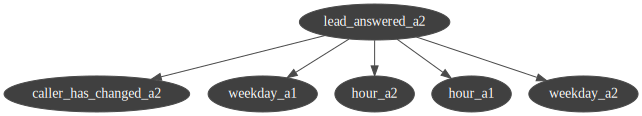

In [ ]:
gnb.showBN(bn_naif, size=10)

In [ ]:
bn_naif.cpt("lead_answered_a2")

(pyAgrum.Potential<double>@0x583822ed52a0) 
  lead_answered_a2 |
no       |yes      |
---------|---------|
 0.8421  | 0.1579  |

In [ ]:
print(y_test)

2802135     no
1422470     no
1899589     no
2014809     no
24274       no
          ... 
185564      no
1381535     no
137709      no
1073928     no
894420     yes
Name: lead_answered_a2, Length: 564820, dtype: category
Categories (2, object): ['no', 'yes']


In [ ]:
# Prédiction
pred_prob_naif = predict(
                          bn_naif,
                          data=X_test,
                          var_target="lead_answered_a2",
                          show_progress=True
                        )

pred_var_naif = pred_prob_naif.idxmax(axis=1).rename("pred")

In [ ]:
print(pred_prob_naif)

lead_answered_a2        no       yes
2802135           0.848277  0.151723
1422470           0.847312  0.152688
1899589           0.839840  0.160160
2014809           0.853973  0.146027
24274             0.846892  0.153108
...                    ...       ...
185564            0.845540  0.154460
1381535           0.836000  0.164000
137709            0.833181  0.166819
1073928           0.837555  0.162445
894420            0.847022  0.152978

[564820 rows x 2 columns]


In [ ]:
print(pred_var_naif)

2802135    no
1422470    no
1899589    no
2014809    no
24274      no
           ..
185564     no
1381535    no
137709     no
1073928    no
894420     no
Name: pred, Length: 564820, dtype: object


In [ ]:
(y_test == pred_var_naif).mean()

0.8421886618745795

Threshold optimal: 0.17414141414141412
Score au seuil optimal (yes): 0.8421886618745795
Score au seuil optimal (no): 0.8421886618745795


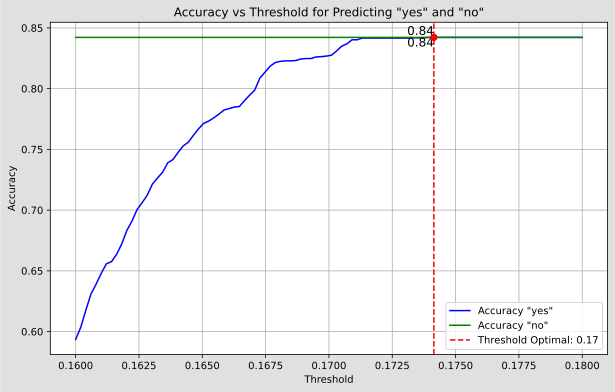

In [ ]:
# Créer une grille de seuils de décision
thresholds = np.linspace(0.16, 0.18, 100)
scores_yes = []
scores_no = []

for thresh in thresholds:
    # Prédiction binaire basée sur le seuil
    pred_binary_yes = pred_prob_naif['yes'].apply(lambda x: "yes" if x > thresh else "no")
    pred_binary_no = pred_prob_naif['no'].apply(lambda x: "no" if x > thresh else "yes")

    # Calculer l'accuracy pour chaque seuil
    score_yes = (y_test == pred_binary_yes).mean()
    score_no = (y_test == pred_binary_no).mean()

    scores_yes.append(score_yes)
    scores_no.append(score_no)

# Trouver l'indice du point de croisement
abs_diff = np.abs(np.array(scores_yes) - np.array(scores_no))
min_diff_idx = np.argmin(abs_diff)  # Index du point le plus proche

# Marquer le point de croisement
cross_point_threshold = thresholds[min_diff_idx]
cross_point_score_yes = scores_yes[min_diff_idx]
cross_point_score_no = scores_no[min_diff_idx]

print(f"Threshold optimal: {cross_point_threshold}")
print(f"Score au seuil optimal (yes): {cross_point_score_yes}")
print(f"Score au seuil optimal (no): {cross_point_score_no}")

# Plot des résultats
plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores_yes, label='Accuracy "yes"', color='blue')
plt.plot(thresholds, scores_no, label='Accuracy "no"', color='green')
plt.axvline(x=cross_point_threshold, color='red', linestyle='--', label=f'Threshold Optimal: {cross_point_threshold:.2f}')
plt.scatter(cross_point_threshold, cross_point_score_yes, color='red', zorder=5)
plt.scatter(cross_point_threshold, cross_point_score_no, color='red', zorder=5)
plt.text(cross_point_threshold, cross_point_score_yes, f'{cross_point_score_yes:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(cross_point_threshold, cross_point_score_no, f'{cross_point_score_no:.2f}', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold for Predicting "yes" and "no"')
plt.legend()
plt.grid(True)
plt.show()


# Modèle simple

In [ ]:
# Entrainement
bn_simple = gum.BayesNet("modele simple")

for var in var_bn.values():
    bn_simple.add(var)

bn_simple.addArc("weekday_a1", "lead_answered_a2")
bn_simple.addArc("weekday_a2", "lead_answered_a2")
bn_simple.addArc("hour_a1", "lead_answered_a2")
bn_simple.addArc("hour_a2", "lead_answered_a2")
bn_simple.addArc("caller_has_changed_a2", "lead_answered_a2")

learner = gum.BNLearner(X_train)
learner.useSmoothingPrior(1)
learner.fitParameters(bn_simple)

(pyAgrum.BNLearner<double>@0x5838298656a0) Filename       : /tmp/tmpug8v_6pq.csv
Size           : (2259276,6)
Variables      : weekday_a1[5], hour_a1[9], weekday_a2[5], hour_a2[9], caller_has_changed_a2[2], lead_answered_a2[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000

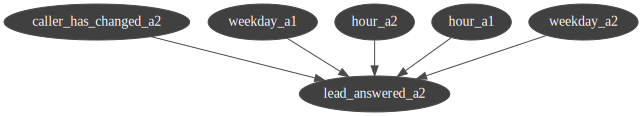

In [ ]:
gnb.showBN(bn_simple, size=10)

In [ ]:
# Prédiction
pred_prob_simple = predict(
                          bn_simple,
                          data=X_test,
                          var_target="lead_answered_a2",
                          show_progress=True
                        )

pred_var_simple = pred_prob_simple.idxmax(axis=1).rename("pred")

In [ ]:
(y_test == pred_var_simple).mean()

0.8421815799723806

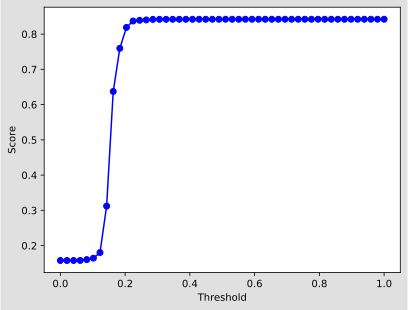

In [ ]:
thresholds = np.linspace(0, 1, 50)
scores = []

for thresh in thresholds:
    pred_binary = pred_prob_simple['yes'].apply(lambda x: "yes" if x > thresh else "no")
    scores.append((y_test == pred_binary).mean())

plt.plot(thresholds, scores, 'bo-')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show()

#Modèle custom


In [ ]:
# Entrainement
bn_custom = gum.BayesNet("modele custom")

for var in var_bn.values():
    bn_custom.add(var)

bn_custom.addArc("lead_answered_a2","weekday_a1")
bn_custom.addArc("lead_answered_a2","hour_a1")
bn_custom.addArc("weekday_a2", "caller_has_changed_a2")
bn_custom.addArc("hour_a2", "caller_has_changed_a2")
bn_custom.addArc("caller_has_changed_a2", "lead_answered_a2")

learner = gum.BNLearner(X_train)
learner.useSmoothingPrior(1)
learner.fitParameters(bn_custom)

(pyAgrum.BNLearner<double>@0x5838392c8d50) Filename       : /tmp/tmpdgwxgwcm.csv
Size           : (2259276,6)
Variables      : weekday_a1[5], hour_a1[9], weekday_a2[5], hour_a2[9], caller_has_changed_a2[2], lead_answered_a2[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000

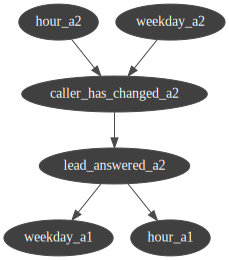

In [ ]:
gnb.showBN(bn_custom, size=10)

In [ ]:
# Prédiction
pred_prob_custom = predict(
                          bn_custom,
                          data=X_test,
                          var_target="lead_answered_a2",
                          show_progress=True
                        )

pred_var_custom = pred_prob_custom.idxmax(axis=1).rename("pred")

In [ ]:
print(pred_var_custom)

2802135    no
1422470    no
1899589    no
2014809    no
24274      no
           ..
185564     no
1381535    no
137709     no
1073928    no
894420     no
Name: pred, Length: 564820, dtype: object


In [ ]:
(y_test == pred_var_custom).mean()

0.8421886618745795

Threshold optimal: 0.16474747474747475
Score au seuil optimal (yes): 0.8421886618745795
Score au seuil optimal (no): 0.8421886618745795


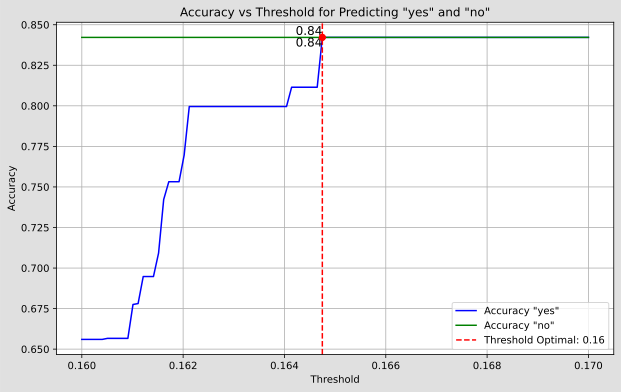

In [ ]:
# Créer une grille de seuils de décision
thresholds = np.linspace(0.16, 0.17, 100)
scores_yes = []
scores_no = []

for thresh in thresholds:
    # Prédiction binaire basée sur le seuil
    pred_binary_yes = pred_prob_custom['yes'].apply(lambda x: "yes" if x > thresh else "no")
    pred_binary_no = pred_prob_custom['no'].apply(lambda x: "no" if x > thresh else "yes")

    # Calculer l'accuracy pour chaque seuil
    score_yes = (y_test == pred_binary_yes).mean()
    score_no = (y_test == pred_binary_no).mean()

    scores_yes.append(score_yes)
    scores_no.append(score_no)

# Trouver l'indice du point de croisement
abs_diff = np.abs(np.array(scores_yes) - np.array(scores_no))
min_diff_idx = np.argmin(abs_diff)  # Index du point le plus proche

# Marquer le point de croisement
cross_point_threshold = thresholds[min_diff_idx]
cross_point_score_yes = scores_yes[min_diff_idx]
cross_point_score_no = scores_no[min_diff_idx]

print(f"Threshold optimal: {cross_point_threshold}")
print(f"Score au seuil optimal (yes): {cross_point_score_yes}")
print(f"Score au seuil optimal (no): {cross_point_score_no}")

# Plot des résultats
plt.figure(figsize=(10, 6))
plt.plot(thresholds, scores_yes, label='Accuracy "yes"', color='blue')
plt.plot(thresholds, scores_no, label='Accuracy "no"', color='green')
plt.axvline(x=cross_point_threshold, color='red', linestyle='--', label=f'Threshold Optimal: {cross_point_threshold:.2f}')
plt.scatter(cross_point_threshold, cross_point_score_yes, color='red', zorder=5)
plt.scatter(cross_point_threshold, cross_point_score_no, color='red', zorder=5)
plt.text(cross_point_threshold, cross_point_score_yes, f'{cross_point_score_yes:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(cross_point_threshold, cross_point_score_no, f'{cross_point_score_no:.2f}', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold for Predicting "yes" and "no"')
plt.legend()
plt.grid(True)
plt.show()